## Sentiment Analysis of Movie Reviews
We want to use [Movie Reviews](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews) as our dataset for our Model

![bp-film-review-title.jpg](attachment:6ec8023c-9e78-4f87-97ce-6cbcd5fa775c.jpg)

## Read dataset file

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
train_df = pd.read_csv('train.tsv',sep='\t')

## Exploratory data

In [2]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


as you see we have a duplicate rows

### Remove duplicate rows

In [3]:
train_df.drop_duplicates(subset=["SentenceId"], keep="first")
print(f"shape : {train_df.shape}")
train_df = train_df.groupby('Sentiment',as_index = False,group_keys=False).apply(lambda s: s.sample(100,replace=True))
print(f"shape : {train_df.shape}")

shape : (156060, 4)
shape : (500, 4)


<Axes: xlabel='Sentiment'>

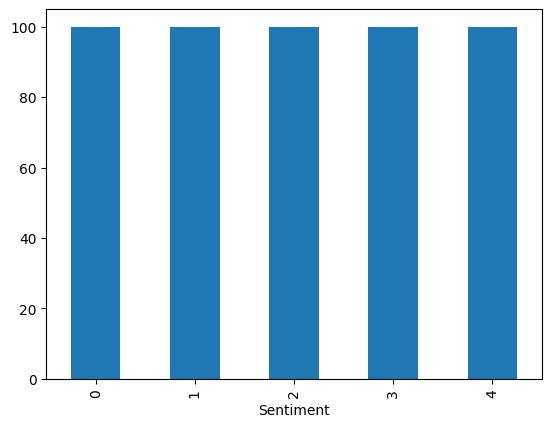

In [4]:
train_df["Sentiment"].value_counts().plot(kind="bar")

The sentiment labels are:

* 0-negative
* 1-somewhat negative
* 2-neutral
* 3-somewhat positive
* 4-positive

In [5]:
seq_len = 512
num_samples = len(train_df)
num_samples

500

### Stratified Sampling

In [6]:
from sklearn.model_selection import train_test_split

feature_var = "Phrase"
target_var = "Sentiment"

X =  train_df[feature_var]
y = train_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [7]:
print(f"X_train : {X_train.shape}" )
print(f"y_train : {y_train.shape}" )
print(f"X_test : {X_test.shape}" )
print(f"y_test : {y_test.shape}" )

X_train : (350,)
y_train : (350,)
X_test : (150,)
y_test : (150,)


<Axes: xlabel='Sentiment'>

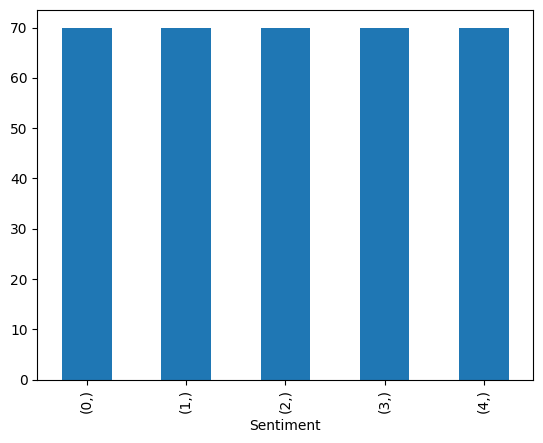

In [8]:
pd.DataFrame(y_train).value_counts().plot(kind = "bar")

## Use Bert tokenizer

In [9]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
tokens_train = tokenizer(X_train.tolist(),
                  max_length=seq_len,
                  truncation=True,
                  padding="max_length",
                  add_special_tokens=True, # the sequences will be encoded with the special tokens relative to their model
                  return_tensors="np")

tokens_test = tokenizer(X_test.tolist(),
                  max_length=seq_len,
                  truncation=True,
                  padding="max_length",
                  add_special_tokens=True, # the sequences will be encoded with the special tokens relative to their model
                  return_tensors="np")

In [11]:
# seq_len = 512
# num_samples = len(train_df)
# X = "Phrase"
# tokens = tokenizer(train_df[X].tolist(),
#                   max_length=seq_len,
#                   truncation=True,
#                   padding="max_length",
#                   add_special_tokens=True, # the sequences will be encoded with the special tokens relative to their model
#                   return_tensors="np")

In [12]:
tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
tokens_train["input_ids"],tokens_train["attention_mask"]

(array([[ 101, 2147, 1011, ...,    0,    0,    0],
        [ 101, 1037, 7199, ...,    0,    0,    0],
        [ 101, 9510, 1999, ...,    0,    0,    0],
        ...,
        [ 101, 2037, 2147, ...,    0,    0,    0],
        [ 101, 1037, 4954, ...,    0,    0,    0],
        [ 101, 1037, 2919, ...,    0,    0,    0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [14]:
tokens_test.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
tokens_test["input_ids"],tokens_test["attention_mask"]

(array([[  101,  2156,  2138, ...,     0,     0,     0],
        [  101,  2019, 25212, ...,     0,     0,     0],
        [  101, 17453, 21743, ...,     0,     0,     0],
        ...,
        [  101,  2009,  2003, ...,     0,     0,     0],
        [  101,  1996,  7700, ...,     0,     0,     0],
        [  101,  1037, 12090, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [16]:
tokens_test["input_ids"].shape

(150, 512)

zeros at the end of seq is related to padding

In [17]:
# classes_arr = train_df["Sentiment"].values
# classes_arr

In [18]:
# labels = np.zeros((num_samples, classes_arr.max()+1))
# labels.shape

In [19]:
labels_train = np.zeros((y_train.shape[0], int(y_train.max()+1)))
print(f"labels_train shape : {labels_train.shape}")
labels_test = np.zeros((y_test.shape[0], int(y_test.max()+1)))
print(f"labels_test shape : {labels_test.shape}")

labels_train shape : (350, 5)
labels_test shape : (150, 5)


In [20]:
labels_train

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

our dataframe has 5 class labels = {0 1 2 3 4}

### make one hot labels

In [21]:
# labels[np.arange(num_samples), classes_arr] = 1
# labels

In [22]:
# y_train.values[:10]

In [23]:
# np.arange(y_train.shape[0])

In [24]:
labels_train[np.arange(y_train.shape[0]), y_train] = 1
labels_test[np.arange(y_test.shape[0]), y_test] = 1

In [25]:
labels_train[:10,:]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

"classes_arr" refer to which column must be 1

## Building a Dataset

[You can see this document if you are not fimiliar with Tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [26]:
import tensorflow as tf

In [27]:
dataset_train = tf.data.Dataset.from_tensor_slices((tokens_train["input_ids"],tokens_train["attention_mask"],labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((tokens_test["input_ids"],tokens_test["attention_mask"],labels_test))

In [28]:
dataset_train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [29]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
# dataset = dataset.map(map_func)
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

dataset_train.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [30]:
# c = 0
# for i in dataset:
#     c += 1
#     if c >= 2:
#         break
#     print(i[0].keys())

## Suffle data

In [31]:
batch_size = 16
dataset_train = dataset_train.batch(batch_size, drop_remainder=False)
dataset_test = dataset_test.batch(batch_size, drop_remainder=False)

In [32]:
dataset_train.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [33]:
# split = 0.9
# size = int(( tokens["input_ids"].shape[0] / batch_size) * split)
# size

## Split data to train and validation

In [34]:
# train_ds = dataset.take(size)
# val_ds = dataset.skip(size)

In [35]:
# train_ds.take(1)

## Now we want to use pretrained bert model

In [36]:
EPOCHS = 10

In [37]:
from transformers import TFAutoModel

In [38]:
bert = TFAutoModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [39]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')


# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
# dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [41]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [42]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

### Callbacks

In [43]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "fine_tuned_BERT_ver1.keras"

keras_callbacks   = [
      EarlyStopping(monitor="val_accuracy", patience=5, mode='max', min_delta=0.0001, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose = 1)
]

In [44]:
# import keras
# keras.backend.clear_session()
import os
os.listdir("/content/")

['.config', 'train.tsv', 'fine_tuned_BERT_ver1.keras', 'sample_data']

In [45]:
history = model.fit(dataset_train, validation_data= dataset_test, epochs= EPOCHS, callbacks=keras_callbacks)

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 1.6446 - accuracy: 0.2486
Epoch 1: val_accuracy improved from -inf to 0.21333, saving model to fine_tuned_BERT_ver1.keras
22/22 [==============================] - 76s 2s/step - loss: 1.6446 - accuracy: 0.2486 - val_loss: 1.5942 - val_accuracy: 0.2133
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 1.5830 - accuracy: 0.2343
Epoch 2: val_accuracy improved from 0.21333 to 0.26000, saving model to fine_tuned_BERT_ver1.keras
22/22 [==============================] - 29s 1s/step - loss: 1.5830 - accuracy: 0.2343 - val_loss: 1.5778 - val_accuracy: 0.2600
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 1.5814 - accuracy: 0.2714
Epoch 3: val_accuracy improved from 0.26000 to 0.27333, saving model to fine_tuned_BERT_ver1.keras
22/22 [==============================] - 34s 2s/step - loss: 1.5814 - accuracy: 0.2714 - val_loss: 1.5728 - val_accuracy: 0.2733
Epoch 4/10
22/22 [===================

In [46]:
# ## Save the trained model
# model.save("fine-tuned-BERT-1.0.keras")

In [47]:
# for i in val_ds:
#     print(i)

In [48]:
# Load saved model
from tensorflow.keras.models import load_model
model_1 = load_model("fine_tuned_BERT_ver1.keras")
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

For saving the time I use just one epoch

In [49]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True,
                                   return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

## first preper data and then sent to our model

In [50]:
test_txt = "Leaping from one arresting image to another , Songs from the Second Floor has all the enjoyable randomness of a very lively dream and so manages to be compelling , amusing and unsettling at the same time ."
# test_txt = "hello world"

In [51]:
# train_df[train_df["Sentiment"] == 4].values

In [52]:
probs = model.predict(prep_data(test_txt))[0]
probs

1/1 [==============================] - 11s 11s/step


array([0.20223407, 0.14300136, 0.11926191, 0.23883173, 0.29667088],
      dtype=float32)

In [53]:
np.argmax(probs)

4

So we have made a test prediction, but we want to be applying this to real phrases from test.tsv. We will load the data into a dataframe, remove fragment duplicates based on SentenceId

In [54]:
pd.set_option('display.max_colwidth', None)
tdf = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')
tdf.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip'

In [ ]:
tdf = tdf.drop_duplicates(subset=['SentenceId'], keep='first')
tdf.head()

Now we initialize our new sentiment column, and begin making predictions

In [ ]:
tdf['Sentiment'] = None

for i, row in tdf.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    tdf.at[i, 'Sentiment'] = pred

tdf.head()